# **NOTEBOOK FOR MACHINE LEARNING PROJECT**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

**Importing Necessary Librarires**

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import Adam, SGD, Adadelta, Adamax
from keras.metrics import categorical_crossentropy
from keras.models import load_model
from PIL import Image, ImageFile
from matplotlib import pyplot as plt
from tensorflow.python.keras.applications import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
ImageFile.LOAD_TRUNCATED_IMAGES = True
tf.test.gpu_device_name()

Using TensorFlow backend.


'/device:GPU:0'

**Providing the Train and Test image paths**

In [2]:
train_path = '/kaggle/input/waste-pictures/train'
test_path = '/kaggle/input/waste-pictures/test'

## **Data Preprocessing with some basic augmentation and preparing the images for input**

In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 128

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   zoom_range = 0.3, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')

test_datagen = ImageDataGenerator(rescale=1./255, 
                                  rotation_range=30, 
                                  zoom_range = 0.3, 
                                  width_shift_range=0.2,
                                  height_shift_range=0.2, 
                                  horizontal_flip = 'true')

In [4]:
train_generator = train_datagen.flow_from_directory(train_path, 
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_path, 
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='categorical')

Found 17872 images belonging to 34 classes.
Found 5756 images belonging to 34 classes.


**Creating the labels.txt file which will be used in the Application**

In [5]:
print(train_generator.class_indices)
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt','w') as f:
    f.write(labels)

{'XLight': 0, 'bandaid': 1, 'battery': 2, 'bowlsanddishes': 3, 'bread': 4, 'bulb': 5, 'cans': 6, 'carton': 7, 'chopsticks': 8, 'cigarettebutt': 9, 'diapers': 10, 'facialmask': 11, 'glassbottle': 12, 'leaflet': 13, 'leftovers': 14, 'medicinebottle': 15, 'milkbox': 16, 'nailpolishbottle': 17, 'napkin': 18, 'newspaper': 19, 'nut': 20, 'penholder': 21, 'pesticidebottle': 22, 'plasticbag': 23, 'plasticbottle': 24, 'plasticene': 25, 'rag': 26, 'tabletcapsule': 27, 'thermometer': 28, 'toothbrush': 29, 'toothpastetube': 30, 'toothpick': 31, 'traditionalChinesemedicine': 32, 'watermelonrind': 33}


# **VGG16**

**Defining the VGG16 model which is pretrained using Imagenet Weights**

In [6]:
base_model_vgg16= tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
    classes=1000
)
base_model_vgg16.trainable = False

model_vgg16 = tf.keras.Sequential([
    base_model_vgg16,
    tf.keras.layers.Conv2D(64,3,activation = 'relu'),
    tf.keras.layers.Dropout(.4),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(34,activation = 'softmax')
])

58892288/58889256 [==============================] - 2s 0us/step


**Setting optimizers and learning rates**

In [7]:
modified_Adam = keras.optimizers.Adam(learning_rate=0.0001)
model_vgg16.compile(loss='categorical_crossentropy',
              optimizer=modified_Adam,
              metrics=['accuracy'])

In [8]:
model_vgg16.summary()
print('Base Model Layers:',len(base_model_vgg16.layers))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 64)          294976    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 34)                2210      
Total params: 15,011,874
Trainable params: 297,186
Non-trainable params: 14,714,688
_________________________________________________________________
Base Model Layers: 19


**Defining Fine tuning layers**

In [9]:
base_model_vgg16.trainable = True
fine_tune_layer = 15
for layers in base_model_vgg16.layers[:fine_tune_layer]:
    layers.trainable = False

**Fitting and Training the Model**

In [10]:
epochs = 25
history_vgg16 = model_vgg16.fit_generator(train_generator, 
                    shuffle = True,
                    epochs = epochs, 
                    validation_data = test_generator)

Epoch 1/25
 17/140 [==>...........................] - ETA: 6:20 - loss: 3.4223 - acc: 0.0869

/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 37/140 [======>.......................] - ETA: 5:19 - loss: 3.3199 - acc: 0.1348

/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 655924 bytes but only got 4265. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7281180688 bytes but only got 0. Skipping tag 8
  " Skipping tag %s" % (size, len(data), tag))


 88/140 [=================>............] - ETA: 2:40 - loss: 3.0921 - acc: 0.2053

/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19398656 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19922944 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 9764864 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to r

139/140 [============================>.] - ETA: 3s - loss: 2.8977 - acc: 0.2611

/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 15335424 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 15859712 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3368026112 bytes but only got 0. Skipping tag 7
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19005440 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

140/140 [==============================] - 601s 4s/step - loss: 2.8948 - acc: 0.2621 - val_loss: 2.5813 - val_acc: 0.3586
Epoch 2/25
140/140 [==============================] - 437s 3s/step - loss: 2.1935 - acc: 0.4423 - val_loss: 2.1961 - val_acc: 0.4317
Epoch 3/25
140/140 [==============================] - 440s 3s/step - loss: 1.9216 - acc: 0.4916 - val_loss: 2.0120 - val_acc: 0.4640
Epoch 4/25
140/140 [==============================] - 441s 3s/step - loss: 1.7773 - acc: 0.5214 - val_loss: 1.8838 - val_acc: 0.5003
Epoch 5/25
140/140 [==============================] - 437s 3s/step - loss: 1.6745 - acc: 0.5408 - val_loss: 1.8081 - val_acc: 0.5160
Epoch 6/25
140/140 [==============================] - 442s 3s/step - loss: 1.6021 - acc: 0.5567 - val_loss: 1.7100 - val_acc: 0.5438
Epoch 7/25
140/140 [==============================] - 438s 3s/step - loss: 1.5527 - acc: 0.5680 - val_loss: 1.6702 - val_acc: 0.5530
Epoch 8/25
140/140 [==============================] - 440s 3s/step - loss: 1.510

**Plotting Training, Testing Loss and Accuracy**

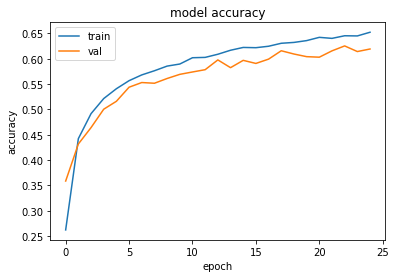

In [11]:
plt.plot(history_vgg16.history['acc'])
plt.plot(history_vgg16.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

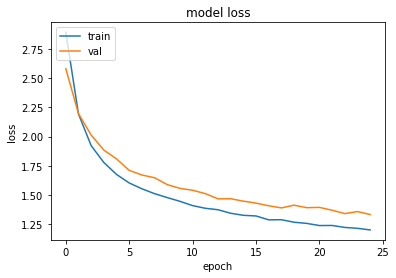

In [12]:
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Saving our trained Models**

In [13]:
model_vgg16.save('model_vgg16.h5')

# **ResNet50**

**Defining the ResNet50 model which is pretrained using Imagenet Weights**

In [17]:
base_model_resnet50 = tf.keras.applications.ResNet50(
    weights='imagenet',
    input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
    include_top=False,
)

base_model_resnet50.trainable = False

model_resnet50 = tf.keras.Sequential([
    base_model_resnet50,
    tf.keras.layers.Conv2D(64,3,activation = 'relu'),
    tf.keras.layers.Dropout(.4),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(34,activation = 'softmax')
])


**Setting Optimizers and Learning Rate**

In [18]:
modified_Adam = keras.optimizers.Adam(learning_rate=0.0001)
model_resnet50.compile(loss='categorical_crossentropy',
              optimizer=modified_Adam,
              metrics=['accuracy'])

In [19]:
model_resnet50.summary()
print('Base Model Layers:',len(base_model_resnet50.layers))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          1179712   
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 34)                2210      
Total params: 24,769,634
Trainable params: 1,181,922
Non-trainable params: 23,587,712
_________________________________________________________________
Base Model Layers: 175


**Setting up Fine Tuning**

In [20]:
base_model_resnet50.trainable = True
fine_tune_layer = 165
for layers in base_model_resnet50.layers[:fine_tune_layer]:
    layers.trainable = False

**Defining the number of epochs**

In [21]:
epochs = 25
history_resnet50 = model_resnet50.fit_generator(train_generator, 
                    shuffle = True,
                    epochs = epochs, 
                    validation_data = test_generator)

Epoch 1/25
 23/140 [===>..........................] - ETA: 4:37 - loss: 2.8905 - acc: 0.2612

/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 655924 bytes but only got 4265. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7281180688 bytes but only got 0. Skipping tag 8
  " Skipping tag %s" % (size, len(data), tag))


 65/140 [============>.................] - ETA: 2:55 - loss: 2.1356 - acc: 0.4407

/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 89/140 [==================>...........] - ETA: 2:00 - loss: 1.9248 - acc: 0.4884

/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19398656 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19922944 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 9764864 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to r

139/140 [============================>.] - ETA: 2s - loss: 1.6711 - acc: 0.5504

/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 15335424 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 15859712 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3368026112 bytes but only got 0. Skipping tag 7
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19005440 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

140/140 [==============================] - 461s 3s/step - loss: 1.6668 - acc: 0.5514 - val_loss: 4.1031 - val_acc: 0.0361
Epoch 2/25
140/140 [==============================] - 432s 3s/step - loss: 0.9923 - acc: 0.7175 - val_loss: 4.4579 - val_acc: 0.0360
Epoch 3/25
140/140 [==============================] - 438s 3s/step - loss: 0.8435 - acc: 0.7506 - val_loss: 4.5373 - val_acc: 0.0361
Epoch 4/25
140/140 [==============================] - 433s 3s/step - loss: 0.7624 - acc: 0.7756 - val_loss: 4.8968 - val_acc: 0.0361
Epoch 5/25
140/140 [==============================] - 432s 3s/step - loss: 0.6845 - acc: 0.7946 - val_loss: 5.2719 - val_acc: 0.0361
Epoch 6/25
140/140 [==============================] - 432s 3s/step - loss: 0.6426 - acc: 0.8063 - val_loss: 5.3587 - val_acc: 0.0365
Epoch 7/25
140/140 [==============================] - 434s 3s/step - loss: 0.5933 - acc: 0.8207 - val_loss: 5.3901 - val_acc: 0.0360
Epoch 8/25
140/140 [==============================] - 445s 3s/step - loss: 0.562

**Plotting relevant loss and accuracy**

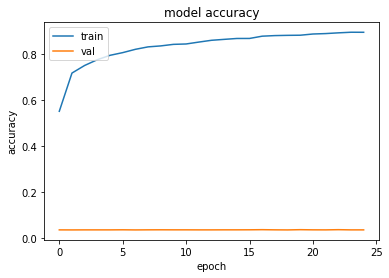

In [22]:
plt.plot(history_resnet50.history['acc'])
plt.plot(history_resnet50.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

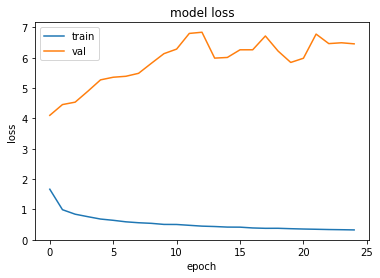

In [23]:
plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
model_resnet50.save('model_resnet50.h5')

# **MobileNetV2**

**Defining the MobileNetV2 model which is pretrained using Imagenet Weights**

In [25]:
base_model_mobilenet = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
    include_top=False,
)

base_model_mobilenet.trainable = False

model_mobilenet = tf.keras.Sequential([
    base_model_mobilenet,
    tf.keras.layers.Conv2D(64,3,activation = 'relu'),
    tf.keras.layers.Dropout(.4),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(34,activation = 'softmax')
])

9412608/9406464 [==============================] - 0s 0us/step


**Setting Optimizers and Learning Rate**

In [26]:
modified_Adam = keras.optimizers.Adam(learning_rate=0.0001)
model_mobilenet.compile(loss='categorical_crossentropy',
              optimizer=modified_Adam,
              metrics=['accuracy'])

In [27]:
model_mobilenet.summary()
print('Base Model Layers:',len(base_model_mobilenet.layers))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 64)          737344    
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 34)                2210      
Total params: 2,997,538
Trainable params: 739,554
Non-trainable params: 2,257,984
_________________________________________________________________
Base Model Layers: 155


**Setting up fine tuning**

In [29]:
base_model_mobilenet.trainable = True
fine_tune_layer = 148
for layers in base_model_mobilenet.layers[:fine_tune_layer]:
    layers.trainable = False

**Defining the number of epochs to be trained**

In [30]:
epochs = 20
history_mobilenet = model_mobilenet.fit_generator(train_generator, 
                    shuffle = True,
                    epochs = epochs, 
                    validation_data = test_generator)

Epoch 1/20
  9/140 [>.............................] - ETA: 5:25 - loss: 3.5067 - acc: 0.0894

/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19398656 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19922944 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 9764864 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to r

108/140 [======================>.......] - ETA: 1:16 - loss: 2.1224 - acc: 0.4443

/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


118/140 [========================>.....] - ETA: 52s - loss: 2.0620 - acc: 0.4580

/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 655924 bytes but only got 4265. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7281180688 bytes but only got 0. Skipping tag 8
  " Skipping tag %s" % (size, len(data), tag))


139/140 [============================>.] - ETA: 2s - loss: 1.9658 - acc: 0.4802

/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 15335424 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 15859712 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3368026112 bytes but only got 0. Skipping tag 7
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19005440 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

140/140 [==============================] - 468s 3s/step - loss: 1.9626 - acc: 0.4812 - val_loss: 1.8260 - val_acc: 0.5186
Epoch 2/20
140/140 [==============================] - 425s 3s/step - loss: 1.1848 - acc: 0.6656 - val_loss: 1.7129 - val_acc: 0.5528
Epoch 3/20
140/140 [==============================] - 420s 3s/step - loss: 1.0402 - acc: 0.7030 - val_loss: 1.7396 - val_acc: 0.5469
Epoch 4/20
140/140 [==============================] - 421s 3s/step - loss: 0.9560 - acc: 0.7247 - val_loss: 1.6858 - val_acc: 0.5681
Epoch 5/20
140/140 [==============================] - 428s 3s/step - loss: 0.9145 - acc: 0.7343 - val_loss: 1.6910 - val_acc: 0.5627
Epoch 6/20
140/140 [==============================] - 428s 3s/step - loss: 0.8661 - acc: 0.7450 - val_loss: 1.6726 - val_acc: 0.5629
Epoch 7/20
140/140 [==============================] - 427s 3s/step - loss: 0.8351 - acc: 0.7558 - val_loss: 1.6561 - val_acc: 0.5754
Epoch 8/20
140/140 [==============================] - 424s 3s/step - loss: 0.802

**Plotting relevant loss and accuracy**

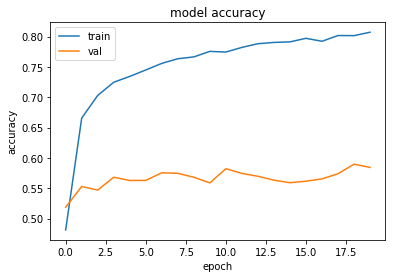

In [31]:
plt.plot(history_mobilenet.history['acc'])
plt.plot(history_mobilenet.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

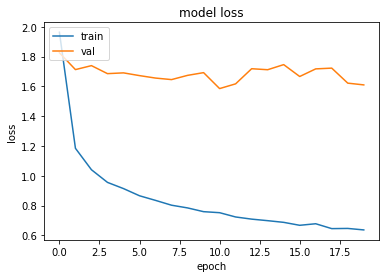

In [32]:
plt.plot(history_mobilenet.history['loss'])
plt.plot(history_mobilenet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [33]:
model_mobilenet.save('model_resnet50.h5')

# **Displaying accuracies From the saved models**

**VGG16**

In [ ]:
model_vgg16 = keras.models.load_model('../input/modelvgg16/updated VGG16.h5')

In [46]:
from sklearn.metrics import confusion_matrix
test_generator.reset()

# Evaluate on Validation data
scores = model_vgg16.evaluate(test_generator)
print("Accuracy:",scores[1]*100)

45/45 [==============================] - 109s 2s/step - loss: 1.3460 - acc: 0.6154
Accuracy: 61.53578758239746


**ResNet50**

In [ ]:
model_resnet50 = keras.models.load_model('../input/modelvgg16/updated VGG16.h5')

In [47]:
from sklearn.metrics import confusion_matrix
test_generator.reset()

# Evaluate on Validation data
scores = model_resnet50.evaluate(test_generator)
print("Accuracy:",scores[1]*100)

45/45 [==============================] - 108s 2s/step - loss: 6.4580 - acc: 0.0360
Accuracy: 3.596247360110283


**MobileNetV2**

In [ ]:
model_mobilenet = keras.models.load_model('../input/modelvgg16/updated VGG16.h5')

In [48]:
from sklearn.metrics import confusion_matrix
test_generator.reset()

# Evaluate on Validation data
scores = model_mobilenet.evaluate(test_generator)
print("Accuracy:",scores[1]*100)

45/45 [==============================] - 108s 2s/step - loss: 1.6217 - acc: 0.5820
Accuracy: 58.20013880729675
